# Notebook Purpose

Implement TCAV using Pytorch for CLIP

# Load Dependencies

In [1]:
#https://github.com/openai/CLIP
# authors Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings), nerdyrodent
# authors vivian
# The original BigGAN+CLIP method was by https://twitter.com/advadnoun
import threading
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import math
import random
from urllib.request import urlopen
from tqdm import tqdm
import sys
import os
sys.path.append('taming-transformers')
from omegaconf import OmegaConf
from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from torch.cuda import get_device_properties
torch.backends.cudnn.benchmark = False
from torch_optimizer import DiffGrad, AdamP, RAdam
from CLIP import clip
import kornia.augmentation as K
import imageio
from PIL import ImageFile, Image, PngImagePlugin, ImageChops
ImageFile.LOAD_TRUNCATED_IMAGES = True
from subprocess import Popen, PIPE
import re

In [2]:


# Check for GPU and reduce the default image size if low VRAM
default_image_size = 256  # >8GB VRAM

class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))

    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()

#NR: Split prompts and weights
def split_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])

def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load CLIP

In [28]:
model, preprocess = clip.load('ViT-B/32', device)


# Image Encoding

In [69]:
image = preprocess(Image.open("square.jpg")).unsqueeze(0).to(device)
image_features = model.encode_image(image.cuda())

FileNotFoundError: [Errno 2] No such file or directory: 'square.jpg'

# Text Encoding

In [70]:
prompt = "square shaped cat"
txt, weight, stop = split_prompt(prompt)

text_features = model.encode_text(clip.tokenize(txt).to(device)).float()

# Running Inference from CLIP (from CLIP repo)

In [27]:
attr = IntegratedGradients(model)

text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

interpretable_embedding = configure_interpretable_embedding_layer = model.token_embedding

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    inputs = (image_features, text_features)
 
    logits_per_image, logits_per_text = model(image, text)
    
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    probs_max = probs.max()
    progs_argmax = probs.argmax()

#     attributions = attr.attribute(inputs=(image, text),
#                                     baselines=(image * 0, text * 0),
#                                     target=progs_argmax,
#                                     n_steps=30)

In [29]:
import os
concept_filenames = os.listdir('tcav/concepts/striped')

In [30]:
negative_filenames = os.listdir('tcav/concepts/random_0')

In [31]:
def encode_images(img_filename, img_dir=""):
    image = preprocess(Image.open(img_dir + img_filename)).unsqueeze(0).to(device)

    image_features = model.encode_image(image.cuda())
    return image_features

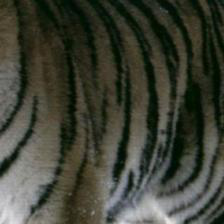

In [9]:
# PIL.Image.open
# concept_filenames[0]

Image.open('tcav/concepts/striped/striped_0086.jpg')

Creating concept vectors from the token embedding

In [32]:
positive_concept = [encode_images(filename, 'tcav/concepts/striped/') for filename in concept_filenames]
positive_concept = torch.vstack(positive_concept)

In [33]:
negative_concept = [encode_images(filename, 'tcav/concepts/random_0/') for filename in negative_filenames]
negative_concept = torch.vstack(negative_concept)

In [34]:
class LinearClassifier(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear1 = torch.nn.Linear(512, 1024)
        self.linear2 = torch.nn.Linear(1024, 512)
        self.linear3 = torch.nn.Linear(512, 1)
        
#         self.relu1 = torch.nn.ReLU()
#         self.relu2 = torch.nn.ReLU()
        
    def forward(self, input_x):
#         x = self.relu1(self.linear1(input_x))
#         x = self.relu2(self.linear2(x))
        x = self.linear1(input_x)
        x = self.linear2(x)
        x = self.linear3(x)
#         x = torch.nn.Sigmoid(x)
        return x.view(-1,1).squeeze(1)



# Assemble training data matrix

In [35]:
positive_labels = torch.tensor(positive_concept.shape[0] * [1])

In [14]:
labels

NameError: name 'labels' is not defined

In [36]:
negative_labels = torch.tensor(negative_concept.shape[0] * [0])

In [37]:
training_data = torch.vstack([positive_concept, negative_concept])

In [49]:
labels = torch.cat([positive_labels, negative_labels])

In [39]:
dataset = TensorDataset(training_data, labels)

loader = DataLoader(dataset, batch_size=2,
                    pin_memory=False, shuffle=True)

criterion = torch.nn.BCEWithLogitsLoss()

In [19]:
import pandas as pd

ModuleNotFoundError: No module named 'pandas'

In [19]:
gcc_training = pd.read_csv("Train_GCC-training.tsv", delimiter="\t",header=None )

NameError: name 'pd' is not defined

In [21]:
captions_split = gcc_training[0].apply(lambda x: x.split(" "))

NameError: name 'gcc_training' is not defined

In [36]:
a = gcc_training.add(' ')

In [ ]:
a[0].sum()

In [25]:
# gcc_training.apply(lambda x:x + ' ').sum(axis=1)




0          a very typical bus station http://lh6.ggpht.co...
1          sierra looked stunning in this top and this sk...
2          young confused girl standing in front of a war...
3          interior design of modern living room with fir...
4          cybernetic scene isolated on white background ...
                                 ...                        
3318328    the teams line up for a photo after kick - off...
3318329    stickers given to delegates at the convention ...
3318330    this is my very favourite design that i recent...
3318331    man driving a car through the mountains https:...
3318332    a longtail boat with a flag goes by spectacula...
Length: 3318333, dtype: object

In [98]:
gcc_training.iloc[3][1]

'https://thumb1.shutterstock.com/display_pic_with_logo/152074/125938838/stock-photo-interior-design-of-modern-living-room-with-fireplace-in-a-new-house-125938838.jpg'

In [46]:
n_epochs = 100
X_train = training_data.cuda().float()
y_train = labels.cuda().float()
model = LinearClassifier().cuda().float()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
for it in range(n_epochs):
    for i, data in enumerate(loader):
        inputs, labels = data
        outputs = model(inputs.cuda().float())
    #     outputs = model(X_train)
        
        loss = criterion(outputs, labels.cuda().float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #     outputs_test = model(X_test)
    #     loss_test = criterion(outputs_test, y_test)

    #     train_losses[it] = loss.item()
    #     test_losses[it] = loss_test.item()

        if (it + 1) % 50 == 0:
#             print(f'In this epoch {it+1}/{n_epochs}, Training loss: {loss.item():.4f}, Test loss: {loss_test.item():.4f}')
            print(f'In this epoch {it+1}/{n_epochs}, Training loss: {loss.item():.4f}')

    #     return train_losses, test_losses

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [44]:
labels.shape

torch.Size([2])

In [ ]:
LinearClassifier().cuda().float().forward(positive_concept.float())

In [50]:
outputs = LinearClassifier().cuda().float().forward(training_data.float())

In [51]:
loss = criterion(outputs, labels.cuda().float())
loss.backward()
optimizer.step()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [64]:
labels

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [77]:
loss

tensor(0.7139, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)